Recreating small-loss trick for improvement of robustness of image classification to noisy labels in tensorflow. Tutorial from https://github.com/filipe-research/tutorial_noisylabels

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, Input
from tensorflow.keras.losses import Loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import random
import time
import pickle
import os

Making saving logs faster using pickle

In [2]:
def write_pickle(log_dict, pickle_name):
    pickle_name += '.pickle'
    pickle_path = os.path.join('./', pickle_name)
    with open(pickle_path, 'wb') as pickle_out:
        pickle.dump(log_dict, pickle_out)
    print(f"Log saved to {pickle_path}.")
    
def read_pickle(pickle_name):
    pickle_name += '.pickle'    
    pickle_path = os.path.join('./', pickle_name)    
    log_dict = {}
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as pickle_in:
            log_dict = pickle.load(pickle_in)
        print(f"Log loaded from {pickle_path}")
    else:
        print(f"File not found : {pickle_path}")
    return log_dict 


Loading MNIST dataset and limiting size to 2000 for fast execution

In [3]:
data_size = 2000
lr = 0.001
batch_size = 128
val_frac = 0.2
num_epochs = 50
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:data_size].astype(np.float32)/255.0
y_train = y_train[:data_size]
x_test = x_test.astype(np.float32)/255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

Preparing datasets and normalizing data

In [5]:
def get_mean_std(images):
    mean = ()
    std = ()
    for i in range(images.shape[-1]):
        mean += (np.mean(images[:, :, :, i]),)
        std += (np.std(images[:, :, :, i]),)
    return mean, std

def normalize(images, mean, std):
    for i in range(images.shape[-1]):
        images[:, :, :, i] = (images[:, :, :, i] - mean[i])/std[i]
    return images

mean, std = get_mean_std(x_train)
x_train = normalize(x_train, mean, std)
x_test = normalize(x_test, mean, std)

In [6]:
def convert_to_one_hot(image, label):
    label = tf.one_hot(label, 10)
    return image, tf.cast(label, tf.float32)

In [7]:
def train_val_split(x_train, y_train, val_frac=0.2):
    perm_idx = np.random.permutation(x_train.shape[0])
    val_idx = perm_idx[:int(val_frac*x_train.shape[0])]
    train_idx = perm_idx[int(val_frac*x_train.shape[0]):]
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    x_train, y_train = x_train[train_idx], y_train[train_idx]
    return (x_train, y_train), (x_val, y_val)

In [8]:
# (x_train_base, y_train_base), (x_val, y_val) = train_val_split(x_train, y_train, 0.2)
x_train_base, y_train_base = x_train, y_train
train_ds = (tf.data.Dataset.from_tensor_slices((x_train_base, y_train_base))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))
# val_ds = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
#                             .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
#                             .batch(batch_size))
test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

Plotting some images

In [9]:
def plot_images(ds):
    plt.figure(figsize=(12, 12))
    for images, targets in ds.take(1):
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.title(np.argmax(targets[i].numpy()))


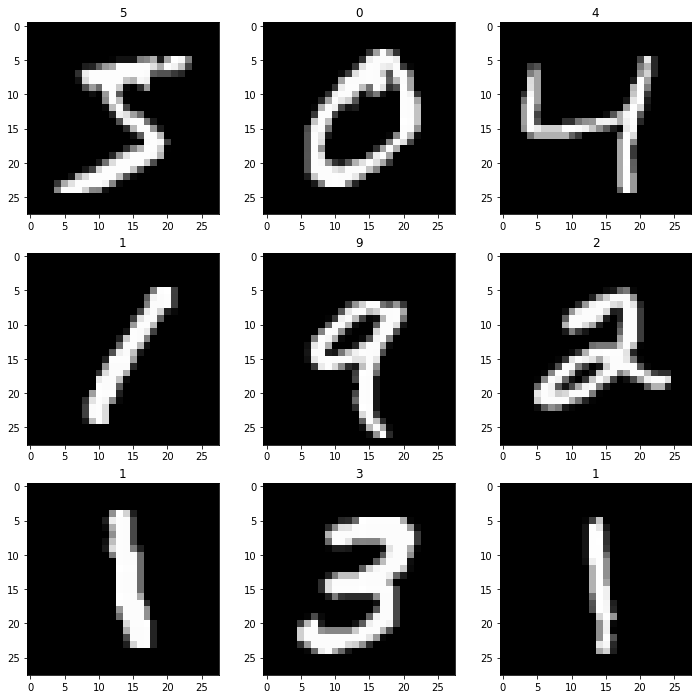

In [10]:
plot_images(train_ds)

Defining model and compile parameters

In [11]:
class base_model(Model):
    def __init__(self, num_classes=10):
        super(base_model, self).__init__()        
        self.conv1 = Conv2D(10, kernel_size = 5, padding='same')
        self.pool1 = MaxPooling2D(pool_size = 2)
        self.conv2 = Conv2D(20, kernel_size = 3, padding = 'same')     
        self.drop1 = Dropout(0.5)
        self.pool2 = MaxPooling2D(pool_size = 2)
        self.flatten = Flatten()
        self.dense1 = Dense(30, activation = 'relu')
        self.drop2 = Dropout(0.5)
        self.dense2 = Dense(num_classes)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.pool1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.drop1(x)
        x = self.pool2(x)
        x = tf.nn.relu(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.drop2(x)
        return self.dense2(x)    
        

Building training, evaluation and testing loops

In [12]:
def fit_gmm(losses):    
    losses = losses.numpy()
    losses = (losses-losses.min())/(losses.max()-losses.min())
    input_loss = np.reshape(losses, [-1, 1])

    gmm = GaussianMixture(n_components=2, max_iter=50, tol=1e-2, reg_covar=5e-4)
    gmm.fit(input_loss)
    prob = gmm.predict_proba(input_loss)
    prob = prob[:, gmm.means_.argmin()]
    return prob

class train_step_func():    
    def __init__(self, loss_f):
        self.loss_fn = loss_f
    
    @tf.function
    def __call__(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)  
            loss = self.loss_fn(y_batch, y_pred)     
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))        
        y_batch_single = tf.math.argmax(y_batch, axis = 1)
        y_pred_single = tf.math.argmax(y_pred, axis = 1)
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0))
        return loss, correct

class val_step_func():
    def __init__(self, loss_f):
        self.loss_fn = loss_f
   
    @tf.function
    def __call__(self, x_batch, y_batch):
        y_pred = model(x_batch)
        loss = self.loss_fn(y_batch, y_pred)
        y_pred_single = tf.math.argmax(y_pred, axis=1)
        y_batch_single = tf.math.argmax(y_batch, axis = 1)  
        correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0)) 
        return loss, correct

@tf.function
def test_step(x_batch, y_batch):    
    y_pred_single = tf.math.argmax(model(x_batch, training=False), axis=1)
    y_batch_single = tf.math.argmax(y_batch, axis = 1)
    correct = tf.math.reduce_sum(tf.where(y_pred_single == y_batch_single, 1.0, 0.0))
    return correct

def train_test_model(
                        train_ds,
                        val_ds,
                        test_ds,
                        loss_func,
                        loss_func_2,
                        num_epochs=1,
                        log_name='log'
                    ):
    logs = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'val_losses':[]}
    num_classes = 10
    len_train_ds = len(list(train_ds.unbatch()))
    len_val_ds = len(list(val_ds.unbatch()))
    len_test_ds = len(list(test_ds.unbatch()))

    for epoch in range(num_epochs):          
        # training
        train_loss = tf.zeros(1)
        train_correct = tf.zeros(1)
        train_step = train_step_func(loss_func) 
        for batch_id, (x_batch, y_batch) in enumerate(train_ds):  
            loss, correct = train_step(x_batch, y_batch)
            train_loss += loss*len(y_batch)
            train_correct += correct
        train_loss /= len_train_ds
        train_acc = train_correct/len_train_ds

        # filter losses
        losses = tf.Variable(tf.zeros(len_val_ds))
        val_step = val_step_func(loss_func_2)
        for idx, (x_batch, y_batch) in enumerate(val_ds):
            loss, _ = val_step(x_batch, y_batch)
            for b in tf.range(x_batch.shape[0]):
                i = batch_size*idx+b
                losses[i].assign(tf.cast(loss[b], tf.float32))
        
        # fit loss to Gaussian mixture model
        prob = fit_gmm(losses)  

        # validation
        val_correct = tf.zeros(1)
        val_loss = tf.zeros(1)
        val_step = val_step_func(loss_func_2)
        for idx, (x_batch, y_batch) in enumerate(test_ds):
            loss, correct = val_step(x_batch, y_batch)
            val_loss += tf.math.reduce_sum(loss)
            val_correct += correct
        val_loss /= float(len_test_ds)
        val_acc = val_correct/len_test_ds      

        logs['train_loss'].append(train_loss[0].numpy())
        logs['train_acc'].append(train_acc[0].numpy())
        logs['val_loss'].append(val_loss[0].numpy())
        logs['val_acc'].append(val_acc[0].numpy())
        logs['val_losses'].append(losses.numpy())

        print(f'Epoch [{epoch+1}/{num_epochs}],\ttrain loss: {train_loss[0].numpy():.4f},\ttrain acc: {train_acc[0].numpy()*100:.2f} %,\tvalidation loss: {val_loss[0].numpy():.4f},\tvalidation accuracy: {val_acc[0].numpy()*100:.2f} %')

    # testing 
    test_correct = tf.zeros(1)
    for x_batch, y_batch in test_ds:
        correct = test_step(x_batch, y_batch)
        test_correct += correct
    test_acc = test_correct/len_test_ds
    print(f"Test accuracy : {test_acc[0].numpy()*100:.2f} %")

    write_pickle(logs, log_name)    
    return logs
    

Setting model optimizer, loss and accuracy metric, compiling and training model

In [13]:
logs_baseline = read_pickle('logs_baseline')
if not bool(logs_baseline):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_baseline = train_test_model(
                                    train_ds, 
                                    train_ds, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    log_name='logs_baseline')
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_baseline.pickle
Epoch [1/50],	train loss: 2.2123,	train acc: 18.75 %,	validation loss: 1.9817,	validation accuracy: 53.95 %
Epoch [2/50],	train loss: 1.7494,	train acc: 38.80 %,	validation loss: 1.5627,	validation accuracy: 65.74 %
Epoch [3/50],	train loss: 1.3859,	train acc: 51.15 %,	validation loss: 1.2133,	validation accuracy: 74.47 %
Epoch [4/50],	train loss: 1.1240,	train acc: 60.60 %,	validation loss: 0.9816,	validation accuracy: 80.43 %
Epoch [5/50],	train loss: 0.9393,	train acc: 67.35 %,	validation loss: 0.8204,	validation accuracy: 83.32 %
Epoch [6/50],	train loss: 0.8105,	train acc: 72.00 %,	validation loss: 0.7070,	validation accuracy: 85.13 %
Epoch [7/50],	train loss: 0.7049,	train acc: 75.10 %,	validation loss: 0.6134,	validation accuracy: 86.16 %
Epoch [8/50],	train loss: 0.6203,	train acc: 79.05 %,	validation loss: 0.5397,	validation accuracy: 87.33 %
Epoch [9/50],	train loss: 0.5521,	train acc: 80.70 %,	validation loss: 0.4825,	validation accura

Text(0, 0.5, 'Loss')

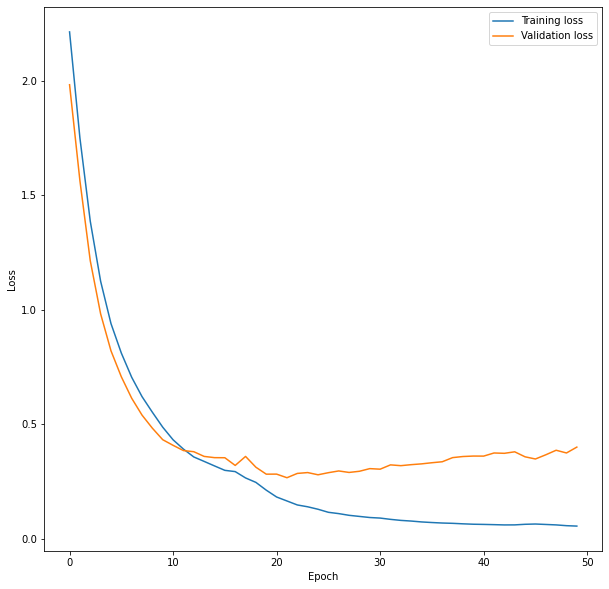

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), logs_baseline['train_loss'], label = 'Training loss')
plt.plot(range(num_epochs), logs_baseline['val_loss'], label = 'Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

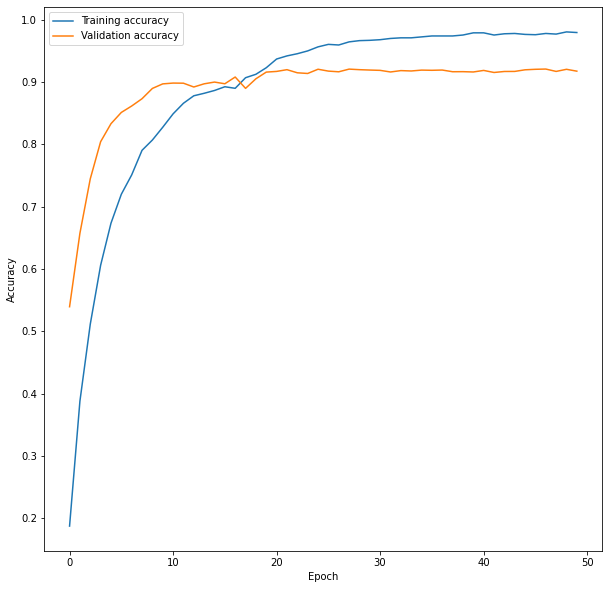

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), logs_baseline['train_acc'], label = 'Training accuracy')
plt.plot(range(num_epochs), logs_baseline['val_acc'], label = 'Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Generate Noisy MNIST

In [16]:
# clean ground truth labels
gt_labels = y_train_base

In [17]:
# generate noise

# class transition for asymmetric noise
transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} 

def generate_noise(nr, gt_labels, noise_mode='sym'):
  noisy_labels = []
  idx = list(range(len(gt_labels)))
  random.shuffle(idx)
  num_noise = int(nr*len(gt_labels))            
  noise_idx = idx[:num_noise]
  for i in range(len(gt_labels)):
      if i in noise_idx:
        if noise_mode=='sym':
          noisylabel = random.randint(0,9)  
          noisy_labels.append(noisylabel)
        elif noise_mode=='asym':   
          noisylabel = transition[gt_labels[i].item()]
          noisy_labels.append(noisylabel)                    
      else:    
        noisy_labels.append(gt_labels[i])  
  return np.array(noisy_labels)

In [18]:
#generate noisy_benchmark
label_noise={}
label_noise['50_sym']=generate_noise(0.5, gt_labels, 'sym')
label_noise['70_sym']=generate_noise(0.7, gt_labels, 'sym')
label_noise['40_asym']=generate_noise(0.4, gt_labels, 'asym')

### Train on noisy datasets baseline

1. 50% symmetric noise

In [19]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['50_sym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

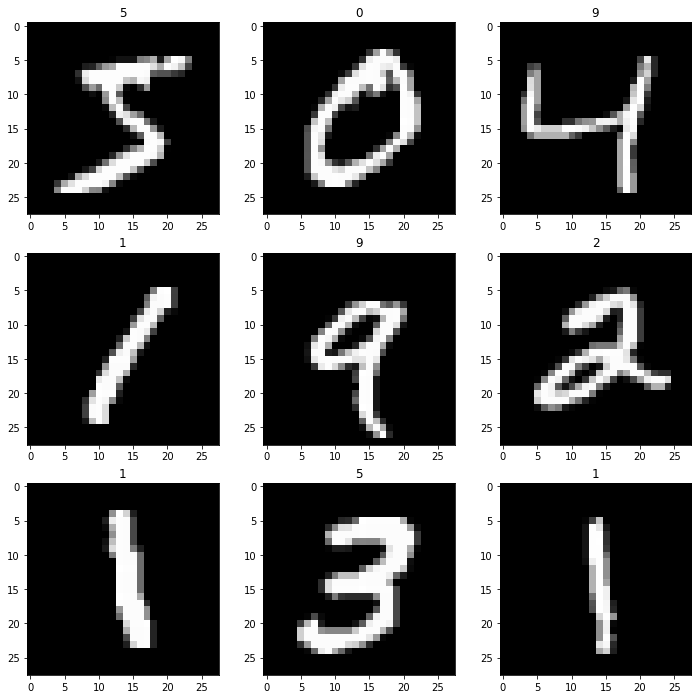

In [20]:
plot_images(train_ds_noisy)

In [21]:
logs_nb_50_sym = read_pickle('logs_nb_50_sym')
if not bool(logs_nb_50_sym):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_nb_50_sym = train_test_model(
                                    train_ds_noisy, 
                                    train_ds_noisy, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    log_name='logs_nb_50_sym')
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_nb_50_sym.pickle
Epoch [1/50],	train loss: 2.3366,	train acc: 12.35 %,	validation loss: 2.2415,	validation accuracy: 38.23 %
Epoch [2/50],	train loss: 2.2241,	train acc: 18.25 %,	validation loss: 2.0892,	validation accuracy: 51.38 %
Epoch [3/50],	train loss: 2.1342,	train acc: 23.40 %,	validation loss: 1.9662,	validation accuracy: 61.45 %
Epoch [4/50],	train loss: 2.0475,	train acc: 28.95 %,	validation loss: 1.8427,	validation accuracy: 68.45 %
Epoch [5/50],	train loss: 1.9692,	train acc: 33.30 %,	validation loss: 1.7530,	validation accuracy: 71.56 %
Epoch [6/50],	train loss: 1.9008,	train acc: 36.60 %,	validation loss: 1.6787,	validation accuracy: 75.23 %
Epoch [7/50],	train loss: 1.8287,	train acc: 39.10 %,	validation loss: 1.6165,	validation accuracy: 78.19 %
Epoch [8/50],	train loss: 1.7648,	train acc: 40.30 %,	validation loss: 1.5840,	validation accuracy: 79.33 %
Epoch [9/50],	train loss: 1.6971,	train acc: 42.20 %,	validation loss: 1.5489,	validation accur

2. 70% symmetric noise

In [22]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['70_sym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

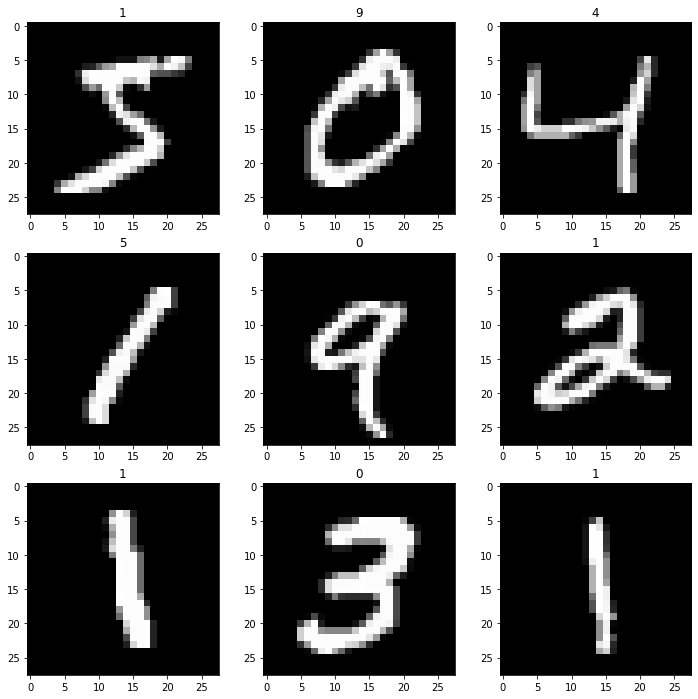

In [23]:
plot_images(train_ds_noisy)

In [24]:
logs_nb_70_sym = read_pickle('logs_nb_70_sym')
if not bool(logs_nb_70_sym):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_nb_70_sym = train_test_model(
                                    train_ds_noisy, 
                                    train_ds_noisy, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    log_name='logs_nb_70_sym')
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_nb_70_sym.pickle
Epoch [1/50],	train loss: 2.3532,	train acc: 11.30 %,	validation loss: 2.2885,	validation accuracy: 10.53 %
Epoch [2/50],	train loss: 2.2900,	train acc: 12.10 %,	validation loss: 2.2795,	validation accuracy: 14.05 %
Epoch [3/50],	train loss: 2.2692,	train acc: 12.25 %,	validation loss: 2.2101,	validation accuracy: 27.11 %
Epoch [4/50],	train loss: 2.2366,	train acc: 16.30 %,	validation loss: 2.1571,	validation accuracy: 31.45 %
Epoch [5/50],	train loss: 2.1987,	train acc: 19.70 %,	validation loss: 2.1143,	validation accuracy: 40.36 %
Epoch [6/50],	train loss: 2.1588,	train acc: 21.30 %,	validation loss: 2.0813,	validation accuracy: 53.26 %
Epoch [7/50],	train loss: 2.1182,	train acc: 23.15 %,	validation loss: 2.0510,	validation accuracy: 55.02 %
Epoch [8/50],	train loss: 2.0732,	train acc: 24.70 %,	validation loss: 2.0107,	validation accuracy: 55.68 %
Epoch [9/50],	train loss: 2.0308,	train acc: 26.35 %,	validation loss: 1.9897,	validation accur

3. 40% asymmetric noise

In [25]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['40_asym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

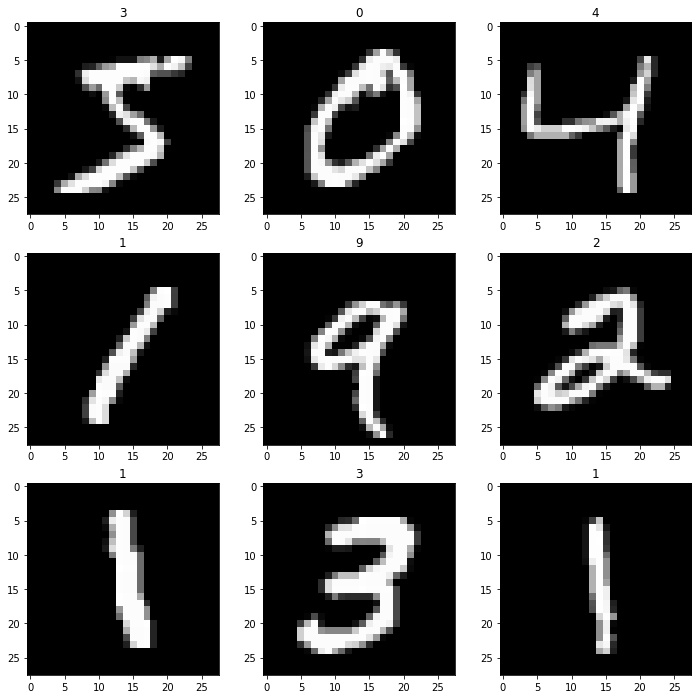

In [26]:
plot_images(train_ds_noisy)

In [27]:
logs_nb_40_asym = read_pickle('logs_nb_40_asym')
if not bool(logs_nb_40_asym):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_nb_40_asym = train_test_model(
                                    train_ds_noisy, 
                                    train_ds_noisy, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    log_name='logs_nb_40_asym')
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_nb_40_asym.pickle
Epoch [1/50],	train loss: 2.2548,	train acc: 16.95 %,	validation loss: 2.0931,	validation accuracy: 37.38 %
Epoch [2/50],	train loss: 1.9116,	train acc: 30.20 %,	validation loss: 1.7930,	validation accuracy: 52.39 %
Epoch [3/50],	train loss: 1.6541,	train acc: 42.10 %,	validation loss: 1.5525,	validation accuracy: 56.78 %
Epoch [4/50],	train loss: 1.4657,	train acc: 48.65 %,	validation loss: 1.4108,	validation accuracy: 59.78 %
Epoch [5/50],	train loss: 1.3329,	train acc: 52.80 %,	validation loss: 1.3118,	validation accuracy: 61.52 %
Epoch [6/50],	train loss: 1.2264,	train acc: 55.30 %,	validation loss: 1.1997,	validation accuracy: 63.94 %
Epoch [7/50],	train loss: 1.1308,	train acc: 57.90 %,	validation loss: 1.1292,	validation accuracy: 65.01 %
Epoch [8/50],	train loss: 1.0543,	train acc: 61.55 %,	validation loss: 1.0407,	validation accuracy: 64.62 %
Epoch [9/50],	train loss: 0.9818,	train acc: 63.15 %,	validation loss: 0.9698,	validation accu

### Plotting results

Text(0, 0.5, 'Loss')

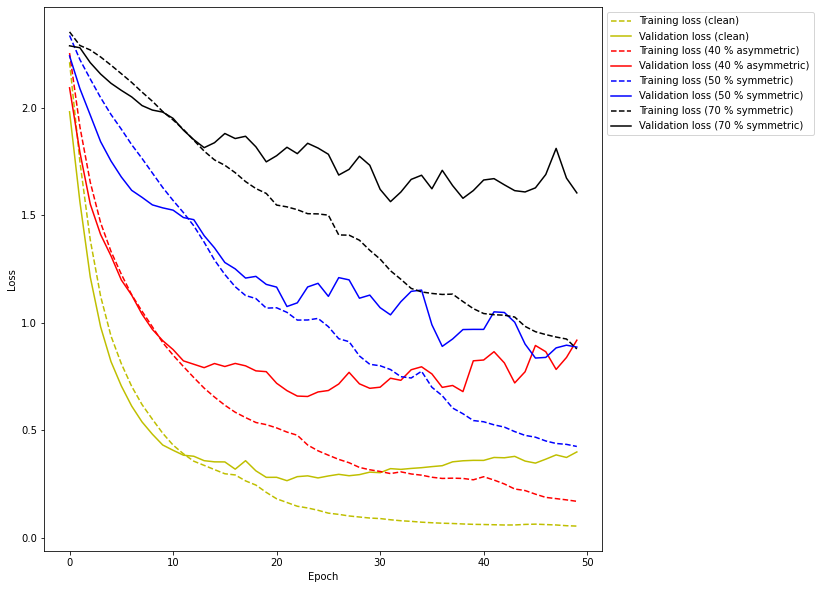

In [28]:
plt.figure(figsize=(10, 10))
logs = [logs_baseline, logs_nb_40_asym, logs_nb_50_sym, logs_nb_70_sym]
log_names = ['clean', '40 % asymmetric', '50 % symmetric', '70 % symmetric']
colors = 'yrbk'
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_loss'], linestyle = '--', color = colors[i], label = 'Training loss ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_loss'], color = colors[i], label = 'Validation loss ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

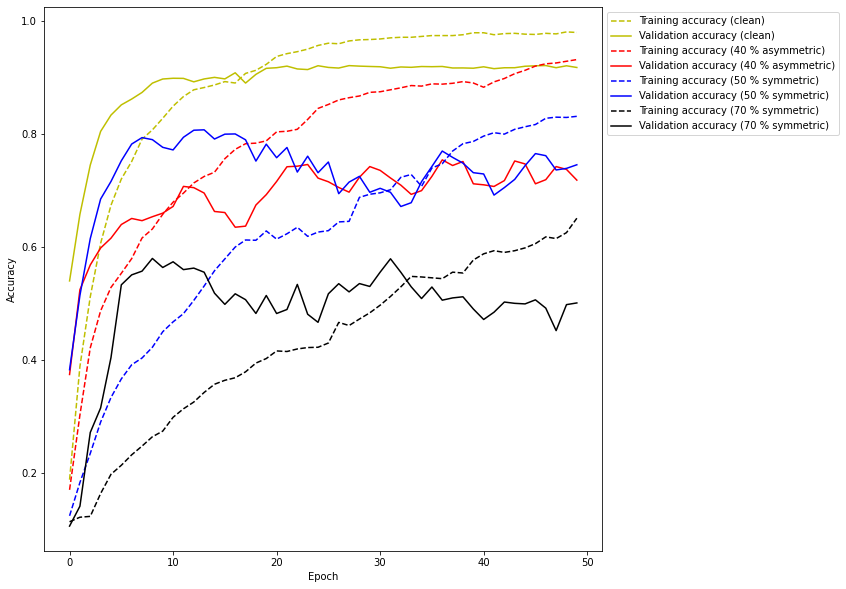

In [29]:
plt.figure(figsize=(10, 10))
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_acc'], linestyle = '--', color = colors[i], label = 'Training accuracy ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_acc'], color = colors[i], label = 'Validation accuracy ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Issues encountered

1. Accuracy metric does not reset itself when running a new model after a previous model has been run. Result is, accuracy is not being tracked throughout model.

**Workaround :**  Train each model only the first time and then reset kernel before training another model.

**Insight :** After the first model is trained, the graph seems to not get destroyed when `tf.keras.backend.clear_session()` is called. This is because when training the second model, the accuracy is being tracked inside the `@tf.function`s but not outside them, where there is eager execution.

**Solution :** Replaced accuracy metric with in place calculation of accuracy using basic tensor operations.

2. After the first model is trained, the second, third and fourth models seem to have loss curves that are almost flat.

**Insight :** The loss functions instantiated after the first model is run, do not get initialized afresh by `tf.keras.backend.clear_session()`, which means that the loss gets tracked from the graph from the first session itself.

**Solution :** Define the tf functions as individual classes, with the loss functions defined inside them.

3. The loss curves and accuracy do not match the ones from the original tutorial

**Insight :** The loss function instantiated repeatedly inside the `@tf.function` does not backpropagate losses effectively. 

**Partial Solution :** Declare loss function within class scope but during initialization.

4. The validation loss is much higher than training loss.

**Solution :** When calling the loss function in `val_step`, change order of y_batch, y_pred

# Combating Noisy Labels

### Robust loss

In [30]:
#Active Passive Loss (ICML 2020)
#paper code: https://github.com/HanxunH/Active-Passive-Losses

In [31]:
class NormalizedCrossEntropy(Loss):
    def __init__(self, num_classes=10, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.scale = scale
    
    def call(self, y_true, y_pred):
        # Expect labels to be one-hot encoded
        y_pred = tf.nn.softmax(y_pred)
        nce = tf.math.reduce_sum(y_true*tf.math.log(y_pred), axis=0)/(tf.math.reduce_sum(tf.math.log(y_pred), axis=0))
        return self.scale*tf.math.reduce_mean(nce)

**Note :** Reduced MAE

Original: `torch.abs(pred - label_one_hot).sum(dim=1)`
       
$MAE = \sum_{k=1}^{K} |\bm{p}(k|\bm{x}) - \bm{q}(k|\bm{x})|$

$MAE = \sum_{k=1}^{K}\bm{p}(k|\bm{x}) - p(y|\bm{x}) + (1 - p(y|\bm{x}))$
       
$MAE = 2 - 2p(y|\bm{x})$
        

In [32]:
class MAE(Loss):
    def __init__(self, scale=1.0):
        super(MAE, self).__init__()
        self.scale = scale
    
    def call(self, y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred)
        mae = tf.math.reduce_mean(1.0-tf.math.reduce_sum(y_true*y_pred, axis=1), axis=0)
        return self.scale*mae

In [33]:
class NCEandMAE(Loss):
    def __init__(self, alpha, beta, num_classes=10):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MAE(scale=beta)
    
    def call(self, y_true, y_pred):
        return self.nce(y_true, y_pred) + self.mae(y_true, y_pred)

Training with Active Passive Loss

In [34]:
# train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['70_sym']))
#                             .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
#                             .batch(batch_size))

In [35]:
# tf.keras.backend.clear_session()
# start_time = time.time()
# tf.random.set_seed(123)
# model = base_model(10)
# loss_func = NCEandMAE(alpha=1.0, beta=1.0, num_classes=10)
# loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
# optimizer = tf.keras.optimizers.Adam(lr)
# logs_nb_70_sym_APL = train_test_model(
#                                 train_ds_noisy, 
#                                 test_ds, 
#                                 test_ds, 
#                                 loss_func, 
#                                 loss_func_2, 
#                                 num_epochs)
# print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

In [36]:
# plt.figure(figsize=(10, 10))
# logs = [logs_baseline, logs_nb_70_sym, logs_nb_70_sym_APL]
# log_names = ['clean', '70 % symmetric', '70 % symmetric with APL']
# colors = 'rbk'
# for i in range(len(logs)):
#     plt.plot(range(num_epochs), logs[i]['train_loss'], linestyle = '--', color = colors[i], label = 'Training loss ('+ log_names[i] + ')')
#     plt.plot(range(num_epochs), logs[i]['val_loss'], color = colors[i], label = 'Validation loss ('+ log_names[i] + ')')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [37]:
# plt.figure(figsize=(10, 10))
# for i in range(len(logs)):
#     plt.plot(range(num_epochs), logs[i]['train_acc'], linestyle = '--', color = colors[i], label = 'Training accuracy ('+ log_names[i] + ')')
#     plt.plot(range(num_epochs), logs[i]['val_acc'], color = colors[i], label = 'Validation accuracy ('+ log_names[i] + ')')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

# Issues encountered

1. When training with APL and 70% symmetric noise, the outputs from the model result in `NaN` values. 

**Insight :** The APL function is unstable with the current model under use. Especially with `ReLU` activation function, the unbounded outputs of the convolutions often result in extreme values

### Loss trick

In [38]:
nl = label_noise['70_sym']
noisy_idx = np.asarray([id for id in range(len(nl)) if nl[id] != gt_labels[id]])
clean_idx = np.delete(np.arange(len(nl)), noisy_idx)

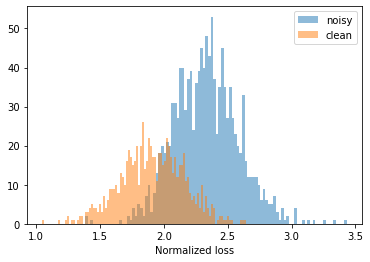

In [39]:
plt.hist(logs_nb_70_sym['val_losses'][10][noisy_idx], label='noisy', bins=100, alpha=0.5)
plt.hist(logs_nb_70_sym['val_losses'][10][clean_idx], label='clean', bins=100, alpha=0.5)
plt.xlabel("Normalized loss")
plt.legend()

In [40]:
avg_loss_clean = [logs_nb_70_sym['val_losses'][i][clean_idx].mean() for i in range(num_epochs)]
avg_loss_noisy = [logs_nb_70_sym['val_losses'][i][noisy_idx].mean() for i in range(num_epochs)]

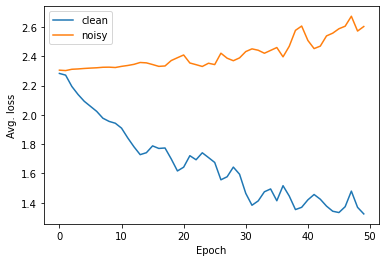

In [41]:
plt.plot(avg_loss_clean, label='clean')
plt.plot(avg_loss_noisy, label='noisy')
plt.xlabel('Epoch')
plt.ylabel('Avg. loss')
plt.legend()

### Removing noisy samples

In [42]:
def train_test_model_and_filter(
                        train_ds,
                        val_ds,
                        test_ds,
                        loss_func,
                        loss_func_2,
                        num_epochs=1,
                        warmup_epochs=10,
                        log_name='log'
                    ):
    logs = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'val_losses':[]}
    num_classes = 10
    len_train_ds = len(list(train_ds.unbatch()))
    len_val_ds = len(list(val_ds.unbatch()))
    len_test_ds = len(list(test_ds.unbatch()))

    for epoch in range(num_epochs):          
        # training        
        len_train_ds = len(list(train_ds.unbatch()))
        train_loss = tf.zeros(1)
        train_correct = tf.zeros(1)
        train_step = train_step_func(loss_func) 
        for batch_id, (x_batch, y_batch) in enumerate(train_ds):  
            loss, correct = train_step(x_batch, y_batch)
            train_loss += loss*len(y_batch)
            train_correct += correct
        train_loss /= len_train_ds
        train_acc = train_correct/len_train_ds

        # filter losses
        losses = tf.Variable(tf.zeros(len_val_ds))
        val_step = val_step_func(loss_func_2)
        for idx, (x_batch, y_batch) in enumerate(val_ds):
            loss, _ = val_step(x_batch, y_batch)
            for b in tf.range(x_batch.shape[0]):
                i = batch_size*idx+b
                losses[i].assign(tf.cast(loss[b], tf.float32))
        
        # fit loss to Gaussian mixture model
        prob = fit_gmm(losses)  

        # validation
        val_correct = tf.zeros(1)
        val_loss = tf.zeros(1)
        val_step = val_step_func(loss_func_2)
        for idx, (x_batch, y_batch) in enumerate(test_ds):
            loss, correct = val_step(x_batch, y_batch)
            val_loss += tf.math.reduce_sum(loss)
            val_correct += correct
        val_loss /= float(len_test_ds)
        val_acc = val_correct/len_test_ds         

        logs['train_loss'].append(train_loss[0].numpy())
        logs['train_acc'].append(train_acc[0].numpy())
        logs['val_loss'].append(val_loss[0].numpy())
        logs['val_acc'].append(val_acc[0].numpy())
        logs['val_losses'].append(losses.numpy())

        # filtering
        if epoch > warmup_epochs:
            pred_idx_clean = (prob > 0.5).nonzero()[0]
            train_clean = list(val_ds.unbatch())
            train_clean_images = np.asarray([image for image, _ in train_clean])[pred_idx_clean, :]
            train_clean_targets = np.asarray([target for _, target in train_clean])[pred_idx_clean, :]
            train_ds = (tf.data.Dataset.from_tensor_slices((train_clean_images, train_clean_targets))
                                        .batch(batch_size))
                                        
        print(f'Epoch [{epoch+1}/{num_epochs}],\ttrain loss: {train_loss[0].numpy():.4f},\ttrain acc: {train_acc[0].numpy()*100:.2f} %,\tvalidation loss: {val_loss[0].numpy():.4f},\tvalidation accuracy: {val_acc[0].numpy()*100:.2f} %')

    # testing 
    test_correct = tf.zeros(1)
    for x_batch, y_batch in test_ds:
        correct = test_step(x_batch, y_batch)
        test_correct += correct
    test_acc = test_correct/len_test_ds
    print(f"Test accuracy : {test_acc[0].numpy()*100:.2f} %")

    write_pickle(logs, log_name)
    return logs

In [43]:
train_ds_noisy = (tf.data.Dataset.from_tensor_slices((x_train_base, label_noise['70_sym']))
                            .map(convert_to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
                            .batch(batch_size))

In [44]:
logs_filter_70_sym = read_pickle('logs_filter_70_sym')
if not bool(logs_filter_70_sym):
    tf.keras.backend.clear_session()
    start_time = time.time()
    tf.random.set_seed(123)
    model = base_model(10)
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_func_2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
    optimizer = tf.keras.optimizers.Adam(lr)
    logs_filter_70_sym = train_test_model_and_filter(
                                    train_ds_noisy, 
                                    train_ds_noisy, 
                                    test_ds, 
                                    loss_func, 
                                    loss_func_2,  
                                    num_epochs,
                                    warmup_epochs=10,
                                    log_name='logs_filter_70_sym')
    print(f"Training time : {(time.time() - start_time)/60:.2f} min.")

File not found : ./logs_filter_70_sym.pickle
Epoch [1/50],	train loss: 2.3532,	train acc: 11.30 %,	validation loss: 2.2885,	validation accuracy: 10.53 %
Epoch [2/50],	train loss: 2.2899,	train acc: 12.20 %,	validation loss: 2.2795,	validation accuracy: 14.23 %
Epoch [3/50],	train loss: 2.2692,	train acc: 12.25 %,	validation loss: 2.2086,	validation accuracy: 27.07 %
Epoch [4/50],	train loss: 2.2370,	train acc: 15.90 %,	validation loss: 2.1675,	validation accuracy: 31.27 %
Epoch [5/50],	train loss: 2.1992,	train acc: 19.00 %,	validation loss: 2.1103,	validation accuracy: 41.80 %
Epoch [6/50],	train loss: 2.1591,	train acc: 20.90 %,	validation loss: 2.0868,	validation accuracy: 51.28 %
Epoch [7/50],	train loss: 2.1150,	train acc: 23.20 %,	validation loss: 2.0433,	validation accuracy: 54.85 %
Epoch [8/50],	train loss: 2.0684,	train acc: 25.05 %,	validation loss: 2.0126,	validation accuracy: 55.41 %
Epoch [9/50],	train loss: 2.0234,	train acc: 26.30 %,	validation loss: 1.9768,	validation a

Text(0, 0.5, 'Loss')

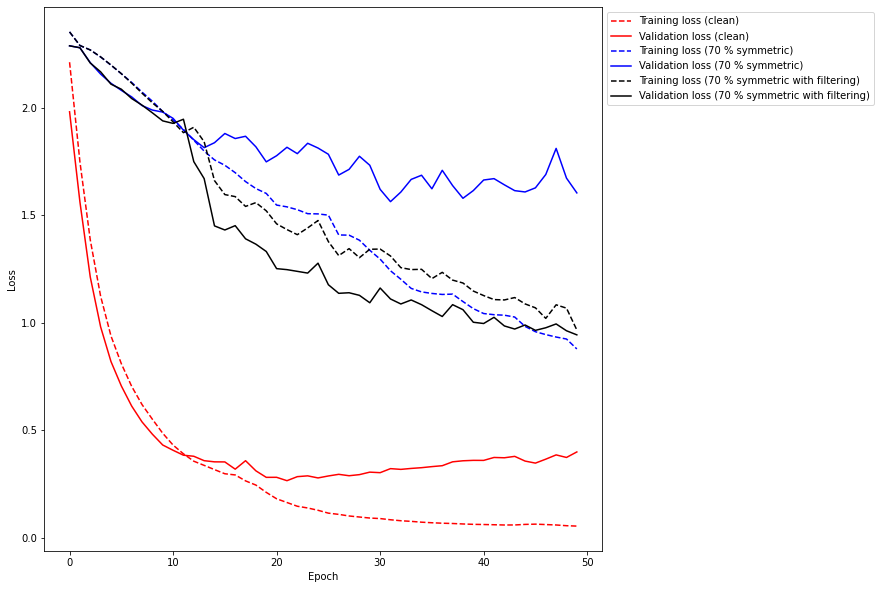

In [45]:
plt.figure(figsize=(10, 10))
logs = [logs_baseline, logs_nb_70_sym, logs_filter_70_sym]
log_names = ['clean', '70 % symmetric', '70 % symmetric with filtering']
colors = 'rbk'
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_loss'], linestyle = '--', color = colors[i], label = 'Training loss ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_loss'], color = colors[i], label = 'Validation loss ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

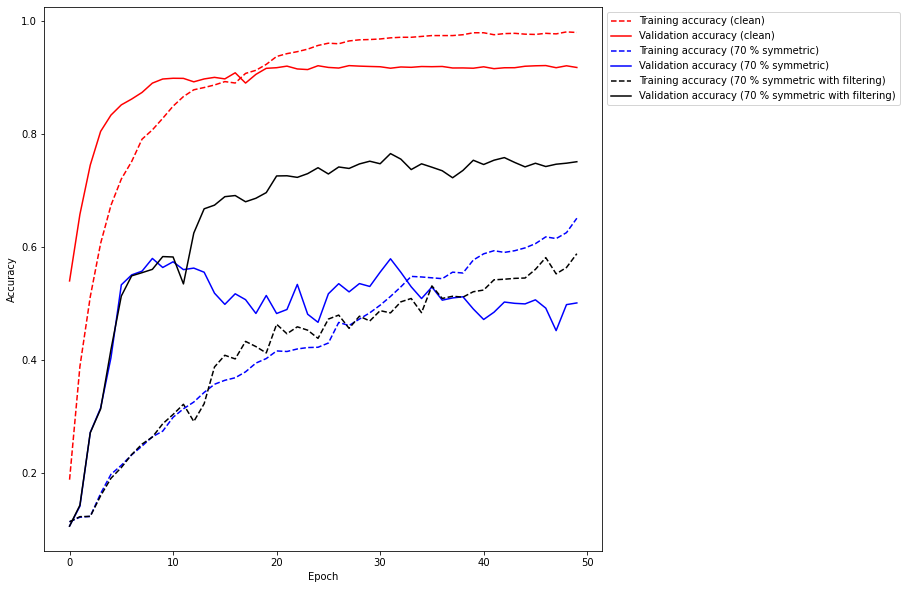

In [46]:
plt.figure(figsize=(10, 10))
for i in range(len(logs)):
    plt.plot(range(num_epochs), logs[i]['train_acc'], linestyle = '--', color = colors[i], label = 'Training accuracy ('+ log_names[i] + ')')
    plt.plot(range(num_epochs), logs[i]['val_acc'], color = colors[i], label = 'Validation accuracy ('+ log_names[i] + ')')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')